In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement= Base.classes.measurement
Station= Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
lastDay= dt.date(2017,8,23)
firstDay= lastDay - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= firstDay).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df= pd.DataFrame(data, columns=["date","Precipitation"])

# Sort the dataframe by date
df.dropna(inplace=True)
df.set_index(["date"], inplace=True)
df.sort_values("date", inplace=True)
df=df[df["Precipitation"]>0]

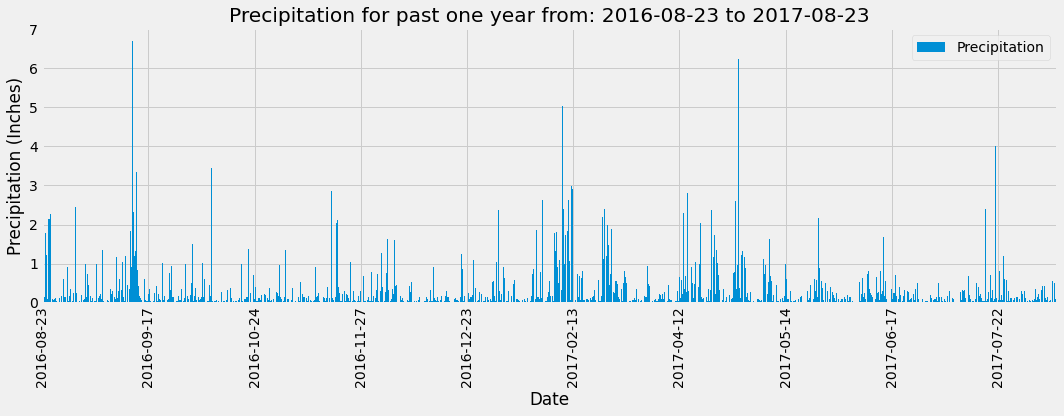

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize= (15,6), width=0.9)
#Labeling the x axis
xtickes= np.arange(0,len(df)+1, 120)
xtickelables= df.index[xtickes].to_list()

plt.xticks(xtickes, xtickelables, rotation=90)
plt.title(f"Precipitation for past one year from: {firstDay} to {lastDay}")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")

plt.tight_layout()
plt.savefig("Images/lastYearPrcp.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

tempRecords = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
tempRecords

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

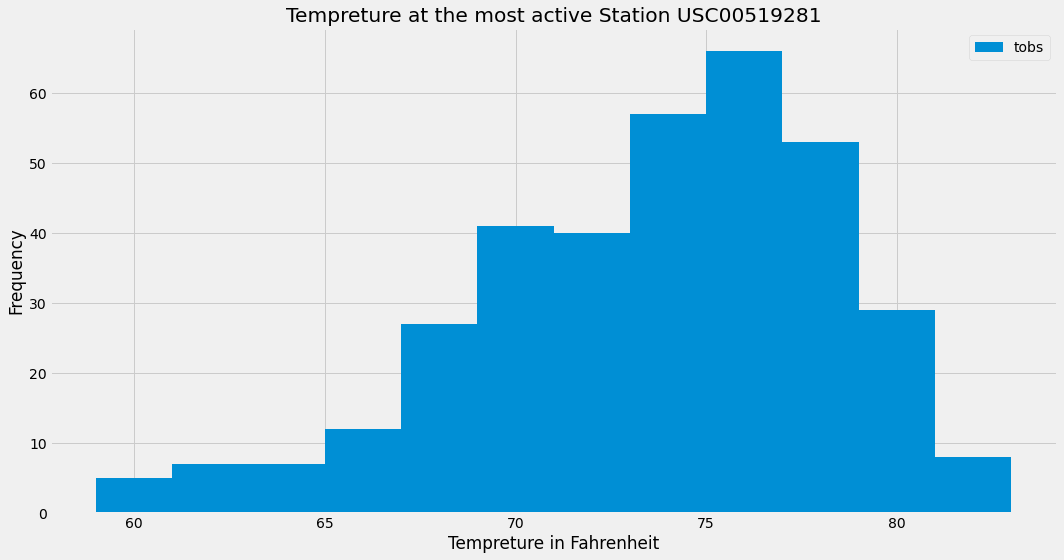

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station, 
       Measurement.tobs]
tempRecords = session.query(*sel).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date <= lastDay).\
    filter(Measurement.date >= firstDay).all()
df_temp12months=pd.DataFrame(tempRecords)
df_temp12months.plot(kind='hist', figsize= (15,8), bins=12)
plt.title("Tempreture at the most active Station USC00519281")
plt.xlabel("Tempreture in Fahrenheit")
plt.tight_layout()
plt.savefig("Images/TempretureAtMostActiveStation.png")
plt.show()

In [19]:
sel = [Measurement.station, 
       Measurement.tobs,
       Measurement.date]
tempRecords = session.query(*sel).\
    filter(Measurement.date <= lastDay).\
    filter(Measurement.date >= firstDay).all()
df_temp12months=pd.DataFrame(tempRecords)
df_temp12months.head()

,station,tobs,date
0,USC00519397,81.0,2016-08-23
1,USC00519397,79.0,2016-08-24
2,USC00519397,80.0,2016-08-25
3,USC00519397,79.0,2016-08-26
4,USC00519397,77.0,2016-08-27


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-28', '2020-8-23'))

[(58.0, 75.67857142857143, 87.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(firstDay, lastDay))

[(58.0, 74.59058295964125, 87.0)]


In [27]:
data_june=session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date)=='06').all()
data_december=session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime('%m', Measurement.date)=='12').all()
df_june= pd.DataFrame(data_june)
df_december= pd.DataFrame(data_december)


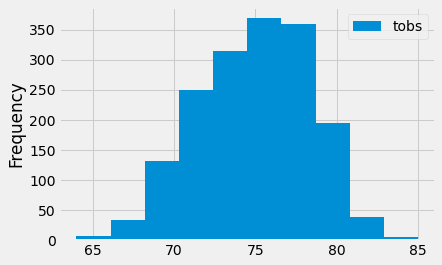

In [28]:
df_june.plot(kind='hist')

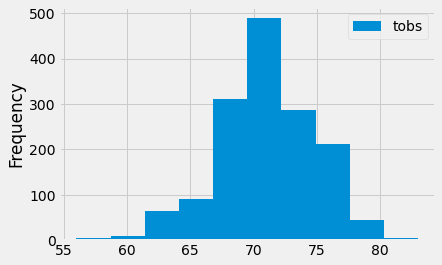

In [29]:
df_december.plot(kind='hist')

In [ ]:
plt.hist()

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df_temp12months.plot(kind="bar")
plt.show()

In [17]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [18]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
